<a href="https://colab.research.google.com/github/KarimOuatt/Abdoul-Karim-Ouattara/blob/main/learn_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pytorch Hands-on Tutorial

This tutorial has been developed for the IFT 3710/6759  *Projets (avancés) en apprentissage automatique* - *(Advanced) Projects in Machine Learning* course at Université de Montréal, Canada.

Course URL: https://alexhernandezgarcia.github.io/teaching/mlprojects/

Author: Dr. Victor Schmidt (former TA) ([Github repository](https://github.com/vict0rsch/pytorch-tutorial))

Adapted by: Alex Hernandez-Garcia ([Github repository](https://github.com/alexhernandezgarcia/pytorch-tutorial))

(Python Beginner? [Here are some recommendations](https://www.notion.so/vsch/Python-recommendations-957ee124321a41fdbaf258cc7dbbfdcb))

## Notebook Outline

0. Utils & Imports
1. Linear Regression with Pytorch
2. Data sets & Data loading
3. Real-world training scenario in Computer Vision
4. Your turn to play around and improve accuracy

The goal of this Notebook is to get you to run things and play around. Little maths are covered here so the basics of Neural Networks and Automatic Differentiation are required for in-depth comprehension.

Official resources:
* [Deep Learning with PyTorch: a 60 Minute Blitz](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html)
* [PyTorch documentation](https://pytorch.org/docs/stable/index.html)

You'll find more pointers at the end of this tutorial

---

## 0. Imports & Utils

Make sure the Notebook is "Connected" with a GPU enabled. Check in the top right.

Let's install a few libraries, nothing fancy

In [1]:
! pip install torch torchvision matplotlib numpy scikit-image torchinfo

Import packages

In [2]:
import random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import skimage.io as io
from pathlib import Path

**Utility functions**: you need not read through this code to understand what will happen in this tutorial.

You **do** however need to *execute* them.

In [3]:
# Plot the time-series of errors and accuracies
# for validation and train splits
def plot_error_and_accuracy(errors, accuracies, title=""):
    """
    Args:
        errors (dict): dictionary of errors over epochs {"train": [], "val": []}
        accuracies (dict): similar, for accuracy
        title (optional, str): Plot title. Defaults to "".
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    x = range(len(errors["train"]))
    ax1.plot(x, errors["train"], label="Training")
    ax1.plot(x, errors["val"], label="Validation")
    ax1.title.set_text("Cross-entropy error")

    ax2.plot(x, accuracies["train"], label="Training")
    ax2.plot(x, accuracies["val"], label="Validation")
    ax2.title.set_text("Prediction Accuracy")

    if title:
        plt.suptitle(title)
    plt.legend()
    plt.show()

In [4]:
# GPUMonitor class to monitor GPU utilization in the background

import subprocess
import shutil
import os


def gpu_util():
    format = "csv,nounits,noheader"
    queries = ["utilization.gpu", "memory.used", "memory.free", "utilization.memory"]
    gpu_query = ",".join(queries)
    gpu_ids = 0

    result = subprocess.run(
        [
            shutil.which("nvidia-smi"),
            f"--query-gpu={gpu_query}",
            f"--format={format}",
            f"--id={gpu_ids}",
        ],
        encoding="utf-8",
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
        check=True,
    )
    stats = [
        [float(x) for x in s.split(", ")]
        for s in result.stdout.strip().split(os.linesep)
    ][0]
    utilization = {}
    for k, q in enumerate(queries):
        utilization[q] = stats[k]
    return utilization


from threading import Thread
from time import sleep, time


class GPUMonitor:
    def __init__(self, timeout=1):
        self.timeout = timeout

        self._thread = Thread(target=self._monitor, daemon=True)
        self.utilization = None
        self.done = False
        self.start_time = self.stop_time = None

    def start(self):
        self._thread.start()
        self.start_time = time()
        return self

    def _monitor(self):
        while True:
            if self.done:
                break
            utilization = gpu_util()
            if self.utilization is None:
                self.utilization = {k: [] for k in utilization}
            for k, v in utilization.items():
                self.utilization[k].append(v)
            sleep(self.timeout)

    def __enter__(self):
        self.start()

    def stop(self):
        self.stop_time = time()
        self.done = True

    def __exit__(self, exc_type, exc_value, tb):
        # handle exceptions with those variables ^
        self.stop()

    def plot_all(self, figsize=(10, 10)):
        f, axs = plt.subplots(2, 2, figsize=figsize)
        for i in range(2):
            for j in range(2):
                ax = axs[i][j]
                k = list(self.utilization.keys())[i * 2 + j]
                data = self.utilization[k]
                ax.plot(range(len(data)), data)
                ax.title.set_text(k)
        plt.suptitle("GPU monitoring")

    def plot(self, k):
        assert k in self.utilization, f"Unknown metric {k}"
        data = self.utilization[k]
        plt.plot(range(len(data)), data)
        plt.title("GPU monitoring: " + k)

In [5]:
# Download a "real world" dataset of 126MB
# in Colab's local disk
def download_data():
    from pathlib import Path
    from urllib.request import urlopen
    from zipfile import ZipFile

    data_path = Path("./tutorial-data")
    data_path.mkdir(exist_ok=True)
    zip_file = data_path / "summer2winter_yosemite.zip"
    unzipped = data_path / "summer2winter_yosemite"

    if zip_file.exists() or unzipped.exists():
        print("Data already exists. Downloading skipped.")
    else:
        url = "https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be66e78_summer2winter-yosemite/summer2winter-yosemite.zip"
        print("Downloading data... ", end="", flush=True)
        with urlopen(url) as response, open(zip_file, "wb") as out_file:
            data = response.read()
            out_file.write(data)
        print("Done.")

        print("Unzipping dataset... ", end="", flush=True)
        with ZipFile(zip_file, "r") as zip:
            zip.extractall(data_path)
        print("Done.")

    print("Available data:")
    for d in unzipped.iterdir():
        if d.is_dir():
            print(f"  {d.name} ({len(list(d.glob('*.jpg')))} images)")

    import shutil

    shutil.move(unzipped / "winter/winter", unzipped / "trainB")
    shutil.move(unzipped / "summer/summer", unzipped / "trainA")
    shutil.move(unzipped / "test_winter/winter", unzipped / "testB")
    shutil.move(unzipped / "test_summer/summer", unzipped / "testA")

    return unzipped

In [6]:
def correct(predictions, labels):
    """
    Counts the number of correct predictions

    Args:
        predictions (torch.Tensor): array of model predictions. Can be either
            1D (batch of class indices) or 2D (batch of prediction vectors)
        labels (torch.Tensor): array of ground truth target labels (1D)
    """
    if predictions.ndim > labels.ndim:
        predictions = predictions.max(1).indices

    correct_predictions = predictions.cpu() == labels.cpu()
    correct_count = correct_predictions.float().sum()
    return correct_count.item()

In [7]:
# From
# https://discuss.pytorch.org/t/reproducibility-with-all-the-bells-and-whistles/81097


def seed_all(seed):
    """
    Seed Python, Numpy and Pytorch for reproducibility.
    """

    if not seed:
        seed = 10

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    # np.random.seed(seed)
    rng = np.random.default_rng(seed=seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    return rng


def seed_worker(worker_id):
    """
    Seed data loader workers
    """
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


rng = seed_all(123)

## 1. Linear Regression

### 1.1 A toy dataset

The data is obtained from a linear model (true distribution)
$$
x \mapsto y:=Ax + b
$$
with $x\in\mathbb R^{input\_dim}$ and $y\in\mathbb R^{output\_dim}$.


For instance, in a circuit, [Ohm's Law](https://en.wikipedia.org/wiki/Ohm%27s_law) states that the electric current through a conductor between two points is directly proportional to the voltage across the two points.

$$
V = R⋅I
$$

In other words, $V$ and $I$ have a *linear* relationship.

In [8]:
input_dim = 1
output_dim = 1

A = 2 * rng.random((output_dim, input_dim)) - 1
b = 2 * rng.random((output_dim)) - 1

true_model = lambda x: A @ x + b

print(
    f"A: {A[0, 0]:.4f}, b:{b[0]:.4f}, x: {2} => A @ x + b: {true_model(np.array([2]))[0]:.4f}"
)

A: 0.3647, b:-0.8924, x: 2 => A @ x + b: -0.1630


We simulate a data set by randomly sampling noisy observations from the true distribution
\begin{align*}
&x_i \sim U([-1, 1])\\
&y_i = A x_i + b + \nu_i
\end{align*}

And then select 1000 samples to train on, 500 to validate and 500 to test

In our example, let's say you want to know the resistance $R$ but can only measure $V$ and $I$. If your instruments were perfect, you could do a single measurement and compute $R = \frac{V}{I}$. If your instruments are imperfect, there may be "noise", imperfections, in the values you read off $V$ after setting the circuit's current to $I$. In this case, you can do several measurements and *regress* $R$ from the known relationship between the two values you measure.

In [9]:
n_samples = 2000
n_train = 1000
noise_level = 0.03

# Generate a random set of n_train samples
X = rng.random((n_samples, input_dim))
Y = np.array([true_model(x) for x in X])

# Add some noise
Y += noise_level * rng.standard_normal(size=Y.shape)

# Train/Val/Test splits
X_train = X[:n_train]
y_train = Y[:n_train]

X_val = X[n_train : n_train + 500]
y_val = Y[n_train : n_train + 500]

X_test = X[n_train + 500 :]
y_test = Y[n_train + 500 :]

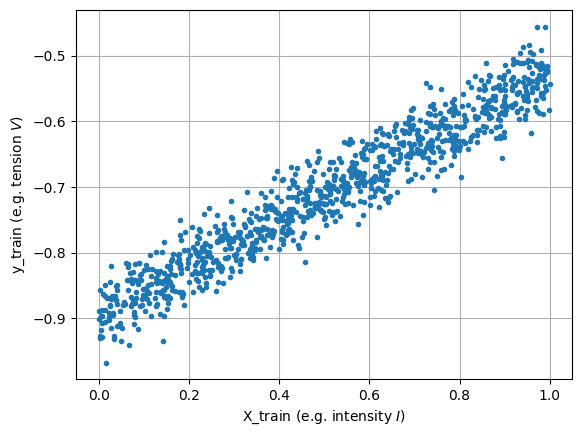

In [10]:
if input_dim == output_dim == 1:
    fig = plt.figure()
    fig.clf()
    ax = fig.gca()
    ax.plot(X_train, y_train, ".")
    ax.grid(True)
    ax.set_xlabel("X_train (e.g. intensity $I$)")
    ax.set_ylabel("y_train (e.g. tension $V$)")

**Task**: fit a model (here a linear model) to recover the true underlying parameters of the data distribution, *i.e.* $A$ and $b$.

### 1.2 Why Pytorch

In a nutshell Pytorch is a computational framework allowing for all kinds of mathematical operations with a focus on 2 particular features that differentiate it from your standard Numpy library:

1. Automatic differentiation
2. GPU acceleration


#### 1.2.1 Autodiff

Recall

$$
(v∘u)'(x) = u'(x) ⋅ (v'∘ u) (x) = u'(x) \cdot v'(u(x))
$$

Let

$$
f: x \rightarrow \log(x^2)
$$
If we want to compute its gradient with respect with some input $x_0$:
$$
\frac{∂\log(x^2)}{\partial x}\rvert_{x=x_0} = \frac{\partial x^2}{\partial x}\rvert_{x=x_0} \cdot \frac{\partial \log(y)}{\partial y} \rvert_{y=x_0^2} = 2x_0 \cdot \frac{1}{x_0^2} = \frac{2}{x_0}
$$
Notice we need not know the derivative of the final complex function, rather that of its individual blocks. This is at the core of Pytorch's `AutoGrad` engine, which automatically computes those intermediate derivatives, whatever the form of the final function and however complex it is. The *only requirement* is that every operation in your function, from the input to the output, is differentiable.




#### 1.2.2 GPU acceleration



In short, at the core of Deep Learning is a bunch of matrix multiplications. The great thing about those is that output values are *independent*: you need not know the value of any $c_{i,j}$ to compute $c_{k,l}$.

Say we want to compute $C = A\times B$:

$$
c_{i,j} = A_{i:}^{\top}B_{:j}
$$

Think of GPUs as thousands of mini-CPUs working in parallel, each of them can compute a different $c_{ij}$ independently of others and in parallel. This is obviously also true for more generic tenor multiplications or element-wise operations.

As a consequence, training neural networks on GPUs can be orders-of-magnitude faster than on CPUs, and Pytorch provides very easy functions to do all your calculations seamlessly on GPUs.

### 1.3 Pytorch Models

In `torch` a model inherits from the class `torch.nn.Module` whose only requirement is to have a `.forward()` method implemented.

In this section we will create a linear model, which takes $x$ as input and produces $y$:

```python
y = model(x)
```

To implement the model, we will create our own Python `class` describing the expected behavior of such a model:
1. what is its architecture? (`__init__(...)`)
2. how does it process inputs it receives? (`forward(...)`)

👋 Your **first exercise** is to fill in the `forward()` method in the `LinearModel` class ⬇️

In [14]:
class LinearModel(nn.Module):
    def __init__(self, in_dim=1, out_dim=1):
        """
        Creates a linear model to predict vectors of size `out_dim`
        from vectors of size `in_dim`:

            y = W @ x + b
            <=>
            y = x @ W^T + b

        Args:
            in_dim (int): the size of the input vectors
            out_dim (int): the size of the output vectors
        """
        # initialization of the parent class
        super().__init__()
        # create a weight matrix. we start with random numbers
        # and they will be adjusted over the course of training
        self.weight = nn.Parameter(torch.randn(out_dim, in_dim))
        # create a bias vector.
        self.bias = nn.Parameter(torch.randn(out_dim))
        # initialize the weight's & bias's values
        self.init()

    # def __call__(self, *args, **kwargs):
    #     # Under the hood, PyTorch implements this __call__() method
    #     # so that ``model(x)`` is equivalent to ``model.forward(x)``
    #     #
    #     # This is FYI, nothing to do here!
    #     return self.forward(*args, **kwargs)

    def init(self):
        """
        Initialize weights and biases according to a normal distribution.
        Look into `nn.init` for more options
        https://pytorch.org/docs/stable/nn.init.html
        """
        nn.init.normal_(self.weight, mean=0, std=0.1)
        nn.init.constant_(self.bias, 0)

    # TODO ⬇️
    def forward(self, x):
        """
        `forward(...)` -> how to produce the output(s) of this model given some input(s)

        make sure that:
            * data types are compatible (e.g. float32 ("float") vs. float64 ("double"))
            * shapes are compatible (usually the first dimension is the batch size)
            * devices are compatible (e.g. CPU vs. GPU) (see later)

        Args:
            x (torch.tensor): input tensor with dimensions [batch_size, in_dim]

        Returns:
            torch.tensor: output tensor with dimensions [batch_size, out_dim]
        """
        assert x.shape[-1] == self.weight.shape[-1]
        y = x * self.weight.T + self.bias
        return y

Now that you have implemented the `forward()` method above, we'll see how we could have done differently and check that it's all equivalent 🎉

In [15]:
# 1️⃣
# create an instance of our custom model class.
model = LinearModel()

# 2️⃣
# as you can imagine, Pytorch has this already implemented.
# Let's compare our implementation with theirs.
simple_model = torch.nn.Linear(1, 1)
#
# make sure the nn.Linear model starts off just like ours
W = model.weight.data
b = model.bias.data
simple_model.weight.data = W
simple_model.bias.data = b

# select a sample x and its associated target y_target
x = torch.tensor(X_train[:1], dtype=torch.float32)  # 👋 Q: why [:1] and not [0]?
y_target = torch.tensor(y_train[:1], dtype=torch.float32)

# 1️⃣ predict y value from sample x
y = model(x)
# 2️⃣ compare with nn.Linear prediction
y_simple = simple_model(x)
# 3️⃣ compare with "manual" calculations
y_manual = x @ W.T + b

In [ ]:
# a bunch of prints to compare all of the above^
print(f"Sample input x       : {x.item():.5f}")
print(f"Model weight         : {model.weight.data}")
print(f"Model bias           : {model.bias.data}")
print(f"\nPredictions:")
print(f"  Model Forward        : {y.item():.5f}")
print(f"  Simple Model Forward : {y_simple.item():.5f}")
print(f"  Manual mat-mul       : {y_manual.item():.5f}")

Wondering what `.item()` means? it turns a single-valued `torch.Tensor` into a Python scalar:

In [ ]:
# FYI: tensor.item(): get a native Python scalar
print(type(x))
print(type(x.item()))

### 1.4 Optimization: learning the model's weights

In this section we'll see how to actually train the model to fit the data.

TL;DR => 1. compute loss 2. update weights

#### 1.4.1 Loss function


We want to compute the regression error made by the predictor as:

$$
L(y, y') = \|y-y'\|_2^2
$$

* for scalars:

    $$
    L(y, y') = (y_i - y_i')^2
    $$

* for vectors

    $$
    L(y, y') = \sum_{d=0}^{out\\_dim-1}(y^{d} - y'^{d})^2
    $$

* for batches (average error)
    $$
    L(y, y') = \frac{1}{N} \sum_{i=0}^{N-1} \sum_{d=0}^{out\\_dim-1}(y^{d}_i - y'^{d}_i)^2
    $$

This function is called the MSE (Mean Squared Error)

👋 Your **second exercise** is to implement the MSE loss in `custom_loss()` ⬇️

In [22]:
def custom_loss(prediction, ground_truth):
    """
    Compute the mean squared error between two tensors.

    Args:
        prediction (torch.tensor): predicted values by some models
        ground_truth (torch.tensor): ground truth values which should have been predicted

    Returns:
        float: mean squared error
    """
    # make sure shapes are compatible
    assert prediction.shape == ground_truth.shape
    error = torch.mean((prediction - ground_truth) ** 2)
    return error

custom_error = custom_loss(y, y_target)

# compare with built-in implementation
torch_loss = torch.nn.MSELoss()
torch_error = torch_loss(y, y_target)

print(custom_error)
print(torch_error)


tensor(0.6509, grad_fn=<MeanBackward0>)
tensor(0.6509, grad_fn=<MseLossBackward0>)


There are many other loss functions in PyTorch, see https://pytorch.org/docs/stable/nn.html#loss-functions

#### 1.4.2 Optimizers


Once the model has made a prediction and its error has been measured with the loss function, we need to update its parameters in the direction of smaller loss.

To that end, PyTorch implements a wide variety of *optimizers*: they take in the model's parameters, a learning rate (and some other stuff sometimes) and will update the parameters based on the loss:

In [23]:
learning_rate = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# also try torch.optim.Adam
# see https://pytorch.org/docs/stable/optim.html#algorithms

What now?

We need to compute the **gradients** so that the optimizer can update the parameters!

For instance the update rule for *gradient descent*:
$$
w' \leftarrow w -\alpha \nabla_\theta L(f_\theta(x), y)
$$

In [24]:
s = "Parameter value: {:.5f} | Parameter gradient: {}"
# recall: error is mse(prediction, ground_truth_target)
for p in model.parameters():
    print(s.format(p.data.item(), p.grad))
print(
    "\nSo far, no gradient is available, we need to call .backward() on the loss\n"
    + "to perform the backward pass and compute the gradient of the loss\n"
    + "with respect to each parameter\n"
)

custom_error.backward()

for p in model.parameters():
    print(s.format(p.data.item(), p.grad.item()))
print()

Parameter value: 0.02103 | Parameter gradient: None
Parameter value: 0.00000 | Parameter gradient: None

So far, no gradient is available, we need to call .backward() on the loss
to perform the backward pass and compute the gradient of the loss
with respect to each parameter

Parameter value: 0.02103 | Parameter gradient: 0.3555757999420166
Parameter value: 0.00000 | Parameter gradient: 1.6136140823364258



Now that gradients have been computed using `.backward()` we will verify using the parameters' `.grad` attributes that the manual SGD update rule is what is in fact done by the optimizer's `.step()` method.

In [25]:
s = "Parameter value: {:.5f} | Parameter gradient: {:.5f} | Updated parameter value should be: {:.5f}"

for p in model.parameters():
    print(
        s.format(p.data.item(), p.grad.item(), (p - learning_rate * p.grad).data.item())
    )
print()

print(
    "Let's perform an 'optimizer step' to update weights according to the\n"
    + "SGD optimization strategy and check that resulting values correspond\n"
    + "to the ones we expect (^)\n"
)

optimizer.step()

for p in model.parameters():
    print("Parameter value: {:.5f} ".format(p.data.item()))
print()

Parameter value: 0.02103 | Parameter gradient: 0.35558 | Updated parameter value should be: 0.02068
Parameter value: 0.00000 | Parameter gradient: 1.61361 | Updated parameter value should be: -0.00161

Let's perform an 'optimizer step' to update weights according to the
SGD optimization strategy and check that resulting values correspond
to the ones we expect (^)

Parameter value: 0.02068 
Parameter value: -0.00161 



#### 1.4.3 Learning rate scheduling

In many practical cases, it helps to adjust your learning rate during training. For instance, start larger early on to make bigger optimization steps, but reduce over the course of training to make smaller steps as you (hopefully) approach a (local?) minimum.

Pytorch uses learning rate "schedulers" to do so:

```python
for e in range(epochs):
    for batch in train_loader:
        ...
        optimizer.step()
    # update the learning rate at the end of an epoch
    scheduler.step()
```

Reference: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

The following piece of code plots how a learning rate scheduler changes the actual learning rate in the optimizer's `step()` over the course of training.

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


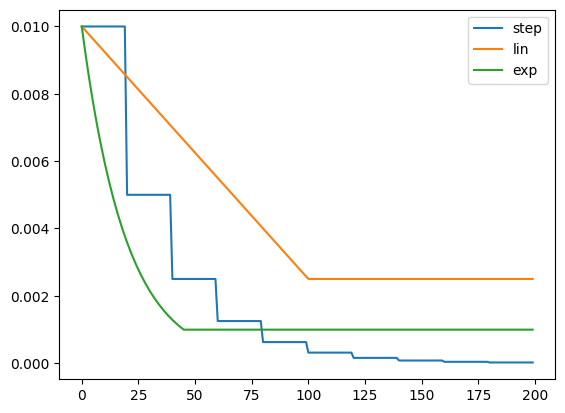

In [26]:
model = LinearModel(1, 1)
optimizer1 = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer2 = torch.optim.SGD(model.parameters(), lr=0.01)
optimizer3 = torch.optim.SGD(model.parameters(), lr=0.01)

# Decay LR by a factor of 0.5 every 20 epochs (lr is halved every 20 epochs)
step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer1, step_size=20, gamma=0.5)
# Grow the learning rate from 0.05 * lr to lr in 100 epochs (learning rate warmup)
lin_lr_scheduler = torch.optim.lr_scheduler.LinearLR(
    optimizer2, start_factor=1, end_factor=0.25, total_iters=100
)
# Multiply the learning rate by 0.9 at each epoch
exp_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer3, 0.95)

lrs = {"step": [], "lin": [], "exp": []}
for epoch in range(200):
    lrs["step"].append(optimizer1.param_groups[0]["lr"])
    lrs["lin"].append(optimizer2.param_groups[0]["lr"])
    lrs["exp"].append(optimizer3.param_groups[0]["lr"])

    step_lr_scheduler.step()
    lin_lr_scheduler.step()
    # you are free to control that descent yourself too!
    if optimizer3.param_groups[0]["lr"] > 1e-3:
        exp_lr_scheduler.step()

for name, data in lrs.items():
    plt.plot(range(len(data)), data, label=name)
plt.legend()
plt.show()

#### 1.4.4 Overall single optimization step

Putting it all together here's what a full sigle optimization step looks like:

1. Define your data, batch size, model, loss, optimizer, etc.
2. Compute your model's prediction from `x`
3. Compute its error with respect to the ground-truth with your `loss`
4. Compute the gradient of the loss with respect to each paramter with `.backward()`
5. Adjust weights accordingly with `optimizer.step()`
6. If need be, adjust the current learning rate with `scheduler.step()`
7. The new error (at least on the same input) is now lower!

In [27]:
batch_size = 32
perm = rng.permutation(len(X_train))

x_batch = X_train[perm[:batch_size]]
y_batch = y_train[perm[:batch_size]]

x = torch.tensor(x_batch, dtype=torch.float32)
y = torch.tensor(y_batch, dtype=torch.float32)

lr = 0.001
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
loss = torch.nn.MSELoss()

y_pred = model(x)
error = loss(y_pred, y)
print(f"Error                                           : {error.item():.5f}")
error.backward()
optimizer.step()
# if you have a scheduler and it is the end of an epoch:
# scheduler.step()

y_pred = model(x)
new_error = loss(y_pred, y)
print(f"New error on the same batch, after SGD update   : {new_error.item():.5f}")
print(f"New loss value is smaller than the previous one : {(new_error < error).item()}")

Error                                           : 0.57927
New error on the same batch, after SGD update   : 0.57656
New loss value is smaller than the previous one : True


### 1.5 Full training procedure

In [28]:
# define hyper-parameters for the training procedure
epochs = 250
batch_size = 32
learning_rate = 0.01

# pre-calculate number of batches in the data sets
n_train_batches = len(X_train) // batch_size
n_val_batches = len(X_val) // batch_size

# initialize model
model = LinearModel(1, 1)
# create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# create loss function
loss = torch.nn.MSELoss()

# Store epoch-wise MSEs
errors = {"train": [], "val": []}

# -----------------------------------
# --  Start of training procedure  --
# -----------------------------------
for e in range(epochs):

    # randomly order training samples at each epoch
    # so they are not always seen together
    perm = rng.permutation(len(X_train))

    # store batch-wise MSE
    train_errors = []

    # ----------------------
    # --  Training epoch  --
    # ----------------------

    for i in range(n_train_batches):

        # select samples and their associated target values
        x_batch = X_train[perm[i * batch_size : (i + 1) * batch_size]]
        y_batch = y_train[perm[i * batch_size : (i + 1) * batch_size]]

        # transform them into torch tensors
        x = torch.tensor(x_batch, dtype=torch.float32)
        y = torch.tensor(y_batch, dtype=torch.float32)

        # make sure all gradients are empty
        optimizer.zero_grad()
        # compute prediction
        y_pred = model(x)
        # compute error
        error = loss(y_pred, y)
        # perform backward pass
        error.backward()
        # update model weights
        optimizer.step()

        # store this batch's MSE
        train_errors.append(error.item())

    # if you have a scheduler: scheduler.step()

    # ------------------------
    # --  Validation epoch  --
    # ------------------------

    val_errors = []
    # temporarily de-activate gradients to speed-up
    # computations as they will not be required in validation
    with torch.no_grad():
        for i in range(n_val_batches):
            # same as training except we don't call .backward() and don't
            # update model weights
            x_batch = X_val[i * batch_size : (i + 1) * batch_size]
            y_batch = y_val[i * batch_size : (i + 1) * batch_size]

            x = torch.tensor(x_batch, dtype=torch.float32)
            y = torch.tensor(y_batch, dtype=torch.float32)

            y_pred = model(x)
            error = loss(y_pred, y)
            val_errors.append(error.item())

    # store average error and some prints

    train_error = np.mean(train_errors)
    val_error = np.mean(val_errors)

    errors["train"].append(train_error)
    errors["val"].append(val_error)

    print(
        f"\rEpoch {e + 1}/{epochs} | Train loss: {train_error:.5f} | Val loss: {val_error:.5f}",
        end="",
    )

    # --------------------
    # --  End of epoch  --
    # --------------------

# ---------------------------------
# --  End of training procedure  --
# ---------------------------------

Epoch 250/250 | Train loss: 0.00087 | Val loss: 0.00081

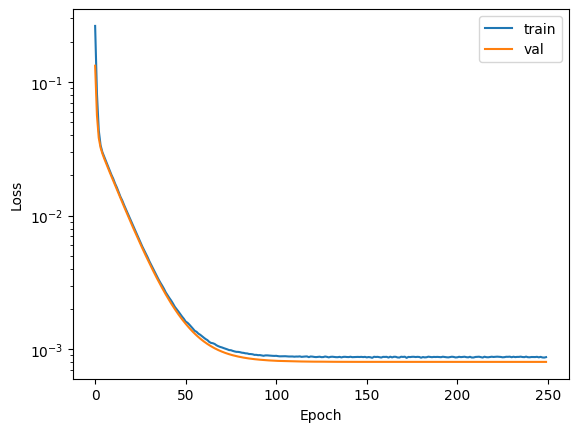

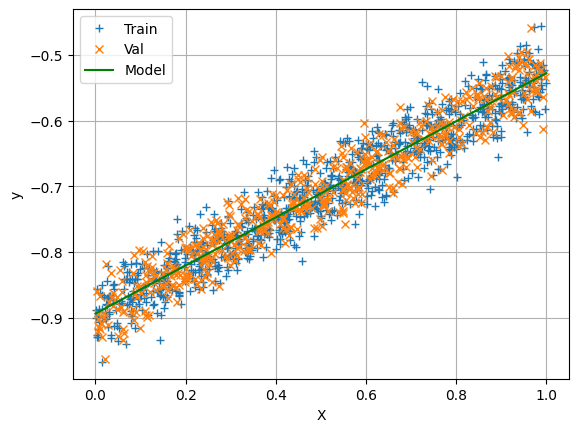

True data parameters   -> slope: 0.36470, bias: -0.00161
SGD-trained parameters -> slope: 0.36596, bias: -0.89368


In [29]:
# Plot train and val losses as functions of epoch number
plt.figure()
plt.plot(errors["train"], label="train")
plt.plot(errors["val"], label="val")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")

# Plot the training and validation data
# alongside the learned model
fig = plt.figure()
fig.clf()
ax = fig.gca()
ax.plot(X_train, y_train, "+", label="Train")
ax.plot(X_val, y_val, "x", label="Val")
ax.grid(True)
ax.set_xlabel("X")
ax.set_ylabel("y")

xs = np.linspace(0, 1, 100)
predictions = [
    model(torch.tensor([x]).float()).item()
    for x in xs
]
plt.plot(xs, predictions, "g-", label="Model")
plt.legend()
plt.show()

print(f"True data parameters   -> slope: {A[0, 0]:.5f}, bias: {b[0]:.5f}")
print(
    f"SGD-trained parameters -> slope: {model.weight.item():.5f}, bias: {model.bias.item():.5f}"
)

## 2. Data sets and data loading

In the previous section, we use the raw data (`X_train[...]`) directly. But in many cases, this is not actually what we do, for instance:

* datasets often don't fit in memory so we need to read the data from the disk when we need it, *i.e.* for each batch
* pre-processings can be heavy (think: image transformations such as resizing, color jittering etc.)

If those steps are slow, then the whole procedure is slowed down not by the training itself, but because the actual training parts of your code have to wait for the data-loading parts.

To that end, `torch` introduces 2 concepts:

* a `Dataset` is an object which define how 1 *single* sample should be processed. In other words, what does it mean for your training code to ask for sample `i`?
* a `Dataloader` is another object which requires a `Dataset` and will take care of (mostly) 2 things for you: 1/ batching dataset samples together 2/ parallelization with background workers (other processes) so that the main training process does not wait.

Ideally, you have enough workers such that your main code `for batch in loader` never waits for the data to be processed, since as soon as a batch is produced, another worker is ready with its own batch and the emptied worker goes back to loading and processing the data in the mean time.

### 2.1 Data sets

A `Dataset` inherits from the `torch.utils.data.Dataset` class, and (in addition to the regular `__init__`) defines at least 2 methods:

* `__len__(self):` which should return an `int` describing the length of the dataset, *i.e.* the number of samples it contains
* `__getitem__(self, i)` which can return "sample `i`" in any form that you want. Typically this is a `torch.Tensor`, or a `tuple` of tensors, or a `dict` of tensors

In [30]:
# let's download some data
data_path = download_data()

Unzipping dataset... Done.
Available data:
  summer (0 images)
  winter (0 images)
  test_winter (0 images)
  test_summer (0 images)


The data we just downloaded contains 2740 `256x256` images of Yosemite National Park, California, divided into train and test sets, and 2 categories: summer pictures or winter pictures.

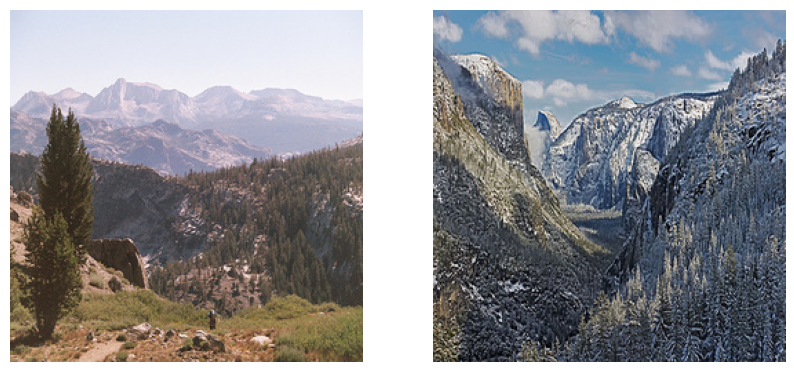

In [31]:
# let's look at sample from both classes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(plt.imread(data_path / "trainA" / "2010-09-11 03:15:45.jpg"))
ax2.imshow(plt.imread(data_path / "trainB" / "2008-01-19 07:55:07.jpg"))
_ = ax1.axis("off")
_ = ax2.axis("off")

In [32]:
# check the shape of each sample
shapes = {"A": set(), "B": set()}

for label in shapes:
    for im_path in (data_path / f"train{label}").glob("*.jpg"):
        im = plt.imread(im_path)
        shapes[label].add(tuple(im.shape))

print(shapes)

{'A': {(256, 256, 3)}, 'B': {(256, 256, 3)}}


Now that we know what data we have, let's create a Pytorch dataset to produce actual data arrays from those image files, along with their associated label, *i.e.* "winter" or "summer"

In [33]:
class ImageDataset(torch.utils.data.Dataset):
    def __init__(self, base_path, train=True, transform=None):
        # where is the data
        self.base_path = Path(base_path)
        # train or validation?
        self.train = train
        # function to transform an image after it has been loaded into an array
        self.transform = transform
        # list of image paths
        self.images = []

        # let's find all relevant image paths
        self.discover_images()

    def discover_images(self):
        # fill the self.images list depending on whether this dataset should produce
        # training or validation samples
        path_A = self.base_path / "trainA" if self.train else self.base_path / "testA"
        path_B = self.base_path / "trainB" if self.train else self.base_path / "testB"

        for im_path in sorted((path_A).glob("*.jpg")):
            self.images.append((im_path, "A"))
        for im_path in sorted((path_B).glob("*.jpg")):
            self.images.append((im_path, "B"))

    def __len__(self):
        # how many sample are available
        return len(self.images)

    def __getitem__(self, i):
        # what is "sample" i?
        # it's a pair of an image tensor and its associated label.
        # let's load the data and return a dictionnary structuring the sample
        # (which could also be a tuple)

        # find sample i
        image_path, label_name = self.images[i]
        # load image into a numpy array
        image = io.imread(image_path)
        # turn the label into an int
        label = 0 if label_name == "A" else 1

        # if a transformation has been provided, modify the
        # loaded image accordingly.
        # For instance: ToTensor() will turn the numpy array into a torch tensor
        if self.transform is not None:
            image = self.transform(image)

        return {"input": image, "label": label}

In [34]:
from torchvision import transforms as T
#Totensor obligatoire, normaliser pour que le modèle reçoive des tra
# Data augmentation
# let's provide a sequence of transformations for the image numpy array:
train_transforms = T.Compose(  # turn a list of functions into a chain
    [
        T.ToTensor(),  # turn the numpy array into a [0; 1] tensor with shape [3x256x256]
        T.RandomResizedCrop( # https://pytorch.org/vision/main/auto_examples/plot_transforms.html#randomresizedcrop
            size=64, scale=(0.5, 0.5)
        ),  # randomly crop and resize the image into a 3x64x64 tensor
        T.RandomHorizontalFlip(),  # randomly flip the image horizontally
        T.Normalize(0.5, 0.5),  # normalize the image so it lands in the [-1; 1] range
    ]
)
# validation transforms are slightly different: let's not randomly modify the input,
# we just want to know how the model performs
validation_transforms = T.Compose([T.ToTensor(), T.Resize(64), T.Normalize(0.5, 0.5)])


train_set = ImageDataset(data_path, train=True, transform=train_transforms)
val_set = ImageDataset(data_path, train=False, transform=validation_transforms)

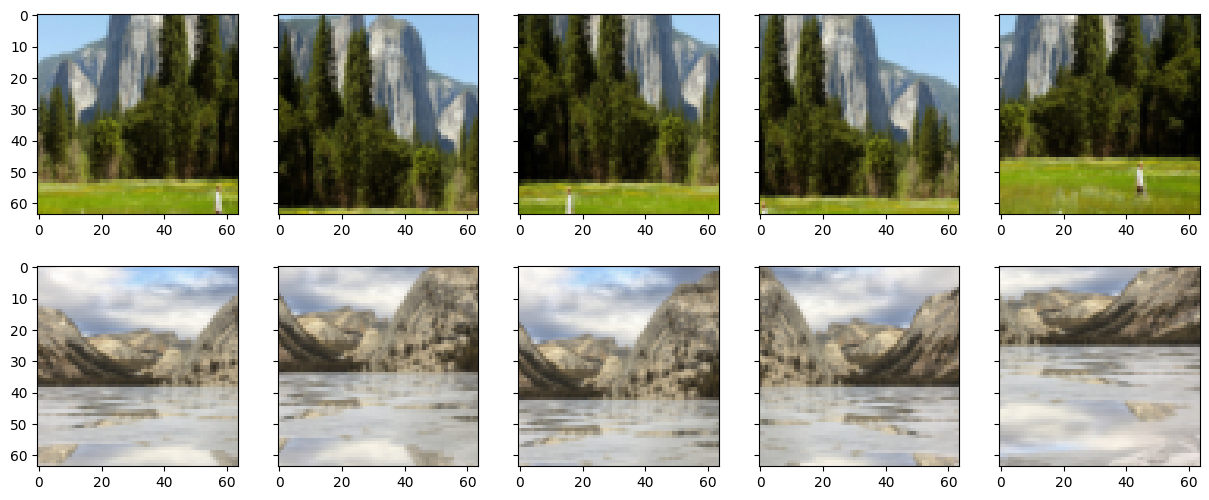

In [35]:
# let's have a look at what the train transforms look like
f, axs = plt.subplots(2, 5, sharey=True, figsize=(15, 6))

for k, idx in enumerate([0, 1500]):
    for p in range(5):
        x = train_set[idx]["input"].permute(1, 2, 0).numpy()
        axs[k][p].imshow((x + 1) / 2)

### 2.2 Data loading

As explained earlier, we can use the `torch.utils.data.DataLoader` class to delegate sample creation and batching to sub-processes in order to free the main process from this burden and make data available faster to the GPU.


In [36]:
train_loader = torch.utils.data.DataLoader(
    train_set,  # what Dataset to use in order to produce individual samples
    batch_size=batch_size,  # how many samples to batch together
    shuffle=True,  # let's not have samples batched together in the same order at each epoch
    num_workers=2,  # how many sub-processes to use in the background; in general set to number of cores in your CPU
    worker_init_fn=seed_worker,  # seed the worker so its inner-random processes are reproducible
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=2
)

### 2.3 Saving and Restoring models

If you are happy with your model, you will want to save it after it is trained for your actual purpose.

If the training procedure stopped (you ran out of time on colab!), you'll want to resume training.

In both (and more) cases, you'll need to save a "checkpoint" of your model during its training. Typically at the end of every epoch if its validation performance is better than the previous epoch's.

Reference: https://pytorch.org/tutorials/beginner/saving_loading_models.html

In [37]:
x = torch.rand((3, 1))

model_1 = LinearModel(1, 1)
model_2 = LinearModel(1, 1)

y_1 = model_1(x)
y_2 = model_2(x)

print("Different models will start off differently:")
print(y_1.detach().numpy())
print(y_2.detach().numpy())

Different models will start off differently:
[[0.06842949]
 [0.05957662]
 [0.01029111]]
[[0.08338998]
 [0.07260163]
 [0.01254101]]


In [38]:
# save the model for future inference:

torch.save(model_1, "./model_1.pt")
# load the full model for future inference
# note that by default weights_only is True for safety reasons
resumed_1 = torch.load("./model_1.pt", weights_only=False)

assert (resumed_1(x) == model_1(x)).all()

In [ ]:
# save the model, the optimizer and any other info using state_dicts

torch.save(
    {
        "model": model_1.state_dict(),
        "optimizer": optimizer.state_dict(),
        "epoch": e,
        "batch_size": batch_size,
    },
    "./state_dicts_1.pt",
)

state_dicts = torch.load("./state_dicts_1.pt")
resumed_dict_1 = LinearModel(1, 1)
resumed_dict_1.load_state_dict(
    state_dicts["model"]
)  # requires the base class of the model

assert (resumed_dict_1(x) == model_1(x)).all()

# exactly the same goes for the optimizer

## 3. Real-world training scenario in Computer Vision

Now that we know how to create a model and train it on some data we can efficiently load from files on disk, let's look at a real world scenario:

Binary classification of summer/winter Yosemite pictures usinc Convolutional Neural Networks (CNNs)

### 3.1 CNN

In [39]:
class ConvBlock(nn.Module):
    def __init__(
        self,
        input_channels,
        output_channels,
        kernel_size=3,
        stride=2,
        bn=True,
        activation=nn.ReLU(),
        dropout=0,
    ):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(
                input_channels, output_channels, kernel_size=3, stride=2, bias=not bn
            ),
            activation,
            nn.BatchNorm2d(output_channels) if bn else nn.Identity(),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.block(x)


class CNN(nn.Module):
    def __init__(
        self,
        input_channels=3,  # how many channels do inputs have?
        conv_channels=[
            32,
            64,
            128,
        ],  # how many convolutional layers (and how many channels)?
        strides=None,  # specify conv. layers' strides (None => automatically set to 1)
        kernel_sizes=None,  # kernel sizes for each conv. layer (None => automatically set to 3)
        batch_norm=True,  # whether or not to use BatchNorm
        activation=nn.LeakyReLU(),  # what non-linearity to use?
        mlp_layers=[
            256,
            64,
            2,
        ],  # how many (and how wide) fully-connected layers in the final predictor
        dropout=0.4,  # probability of setting "neurons" to 0 at train-time
        classes=2,  # how many classes for this task, i.e. the model's output layer size
    ):
        super().__init__()

        # initialize kernel sizes and strides if not provided
        if kernel_sizes is None:
            kernel_sizes = [3] * len(conv_channels)
        if strides is None:
            strides = [1] * len(conv_channels)

        # convolutional layers' number of channels
        channels = [input_channels] + conv_channels

        conv_layers = []

        for i in range(len(channels) - 1):
            input_c = channels[i]
            output_c = channels[i + 1]
            # create a convolutional layer
            conv_layers.append(
                ConvBlock(
                    channels[i],
                    channels[i + 1],
                    kernel_sizes[i],
                    strides[i],
                    batch_norm,
                    activation,
                    dropout,
                )
            )

        # turn the list into a torch.nn.Module that automatically
        # chains .forward() calls
        self.conv_layers = nn.Sequential(*conv_layers)

        # average features across the spatial dimension.
        # the output shape will be batch_size x conv_channels[-1] x 1 x 1
        self.aggregation = nn.AdaptiveAvgPool2d(1)

        mlp = []
        mlp_sizes = [conv_channels[-1]] + mlp_layers
        for i in range(len(mlp_sizes) - 1):
            # create a linear layer
            mlp.append(nn.Linear(mlp_sizes[i], mlp_sizes[i + 1]))
            # add non-linearity
            mlp.append(activation)
            # add dropout
            mlp.append(nn.Dropout(dropout))

        # again, turn list into module
        self.mlp = nn.Sequential(*mlp)

    def forward(self, x):
        # how to process a sample through the model?

        # compute the output feature maps after all convolutional layers
        y = self.conv_layers(x)
        # aggregate features into a vector
        y = self.aggregation(y)
        # reshape to batch_size x conv_channels[-1] for the mlp
        y = y.view(y.size(0), -1)
        # forward through the mlp
        y = self.mlp(y)
        return y

Let's inspect the model and look at the shapes of intermediate features

In [40]:
model = CNN()

print(model)
print("\nShape of intermediate features through the network:")
dummy = torch.rand(7, 3, 64, 64)
print(f"Input: {tuple(dummy.shape)}")
for layer in model.conv_layers:
    dummy = layer(dummy)
    if isinstance(layer, nn.Conv2d):
        print(f"  ->  {layer} -> {tuple(dummy.shape)}")
dummy = model.aggregation(dummy)
print(f"  ->  {model.aggregation} -> {tuple(dummy.shape)}")
dummy = dummy.view(dummy.size(0), -1)
print(f"  ->  Reshape -> {tuple(dummy.shape)}")
for layer in model.mlp:
    dummy = layer(dummy)
    if isinstance(layer, nn.Linear):
        print(f"  ->  {layer} -> {tuple(dummy.shape)}")

CNN(
  (conv_layers): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.4, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.4, inplace=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (aggregatio

In [41]:
from torchinfo import summary

summary(model, input_size=(7, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [7, 2]                    --
├─Sequential: 1-1                        [7, 128, 7, 7]            92,544
│    └─ConvBlock: 2-1                    [7, 32, 31, 31]           --
│    │    └─Sequential: 3-1              [7, 32, 31, 31]           928
├─Sequential: 1-6                        --                        (recursive)
│    └─LeakyReLU: 2-2                    [7, 32, 31, 31]           --
├─Sequential: 1-7                        --                        (recursive)
│    └─ConvBlock: 2-3                    --                        (recursive)
│    │    └─Sequential: 3-2              --                        (recursive)
│    └─ConvBlock: 2-4                    [7, 64, 15, 15]           --
│    │    └─Sequential: 3-3              [7, 64, 15, 15]           18,560
├─Sequential: 1-6                        --                        (recursive)
│    └─LeakyReLU: 2-5          

### 3.2 GPUs

As explained earlier, one of the main reasons to use Pytorch (or Tensorflow etc.) instead of Numpy, is that you can do all the mathematical operations in your model on a GPU.

Let's look at how to do this in Pytorch

In [49]:
torch.tensor(1).device

device(type='cpu')

In [50]:
# do you have a GPU?
torch.cuda.is_available()

True

In [55]:
# how to put tensors onto the GPU?
if torch.cuda.is_available():
    # creating a tensor directly on the device is the preferred and fastest way to do so
    print(torch.tensor(1, device="cuda:0"))
    # alternatives:
    print(torch.tensor(1).to(torch.device("cuda:0")))
    print(torch.tensor(1).to("cuda:0"))
    print(torch.tensor(1).cuda())

tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')
tensor(1, device='cuda:0')


In [56]:
# be careful: two intereacting tensors should (most often) live on the same device!
if torch.cuda.is_available():
    torch.rand((10, 10), device="cpu") * torch.tensor(2, device="cuda:0")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

In [58]:
# models should be on GPUs too!
if torch.cuda.is_available():
    model = LinearModel(1, 1).to("cuda:0")
    x = torch.rand((5, 1))
    try:
        model(x)
    except RuntimeError as e:
        print("Woops:")
        print("  -> " + str(e))
    # let's send the input to the GPU
    model(x.to("cuda:0"))
    print("Ok on GPU!")

Woops:
  -> Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!
Ok on GPU!


In [60]:
# bring a tensor back to the CPU before you turn them
# into numpy arrays or native types
if torch.cuda.is_available():
    tensor = torch.rand((3, 3, 3), device="cuda:0")
    array = tensor.cpu().numpy()
    mean = tensor.mean().cpu().item()
    mean = tensor.cpu().mean().item()

### 3.3 Let's train!

Before we get into the actual training, let's recall the training procedure pseudo code:

```python
# create the main objects of your training procedure:
# loaders, model, loss function & optimizer
train_loader, val_loader = my_loaders(**kwards)
model = MyModel().to(device)
optimizer = Optimizer()
loss = LossFunction()

for epoch in range(n_epoch):

    for batch, target in train_loader:

        # don't forget devices
        x = batch.to(device)
        y = target.to(device)
        
        # don't let gradients accumulate!
        optimizer.zero_grad()
        
        # forward the input through your model
        prediction = model(x)
        
        # compute the error using your loss function
        error = loss(prediction, y)
        
        # perform backward pass to compute gradients
        error.backward()

    # evaluate your model after each epoch (or less often, your choice)
    eval_metric = evaluation_procedure(model, val_loader)

    # save model if it's the best one so far
    if eval_metric > best_eval_metric:
        # use state_dict to be able to continue training
        save(model, optimizer, epoch, batch_size)
        

```

**Great!** We have a model and the know-how to train it on a GPU, let's goooo

In [61]:
# hyper parameters
batch_size = 32
epochs = 50
lr = 0.01

# create device based on GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# create CNN model
model = CNN().to(device)

# as before: create optimizer and loss
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss = torch.nn.CrossEntropyLoss()

# store train/val error & accuracy
errors = {
    "train": [],
    "val": [],
}

accuracies = {"train": [], "val": []}

# initialize loaders
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, num_workers=4
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=batch_size, shuffle=False, num_workers=4
)

print(model)

# custom object in order to monitor how much we use the GPU
# you can have a look at it in 0. Imports and Utils
monitor = GPUMonitor()
monitor.start()

# ---------------------------------------
# --  Start of the training procedure  --
# ---------------------------------------

for e in range(epochs):

    train_errors = []
    train_correct = 0

    # Dropout and BatchNorm behave differently if you are training or evaluating
    # the model. Here we need them to be in training mode
    # (for instance, no dropout in evaluation mode)
    model.train()

    # ignore: clear print line
    print(" " * 100, end="")

    for i, batch in enumerate(train_loader):
        print(f"\rEpoch {e+1}/{epochs} | Train Batch {i+1}/{len(train_loader)}", end="")

        # clear gradients
        optimizer.zero_grad()

        # send tensors to the propper device
        x = batch["input"].to(device)
        y = batch["label"].to(device)

        # forward through model
        prediction = model(x)
        # compute prediction error
        error = loss(prediction, y)
        # update model parameters
        optimizer.step()

        # store batch error
        train_errors.append(error.cpu().item())
        # store batch correct count (see 0. ) to compute accuracy
        # on the full training set for this epoch
        train_correct += correct(prediction, batch["label"])

    # clear print line
    print(" " * 100, end="")

    # evaluation: no gradients needed
    with torch.no_grad():
        val_errors = []
        val_correct = 0

        # Put the model in evaluation mode (vs .train() mode)
        model.eval()

        for i, batch in enumerate(val_loader):
            print(
                f"\rEpoch {e+1}/{epochs} | Validation Batch {i+1}/{len(val_loader)}",
                end="",
            )
            prediction = model(batch["input"].to(device))
            error = loss(prediction, batch["label"].to(device))
            val_errors.append(error.cpu().item())
            val_correct += correct(prediction, batch["label"])

    # compute average errors
    train_error = np.mean(train_errors)
    val_error = np.mean(val_errors)

    # compute epoch-wise accuracies
    train_acc = train_correct / len(train_set) * 100
    val_acc = val_correct / len(val_set) * 100

    # store metrics
    accuracies["train"].append(train_acc)
    accuracies["val"].append(val_acc)
    errors["train"].append(train_error)
    errors["val"].append(val_error)

    print(
        f"\rEpoch {e+1}/{epochs} - Train error: {train_error:.4f} Train acc: {train_acc:.1f}% - Val error: {val_error:.4f} Val acc: {val_acc:.1f}%"
    )

    # -------------------
    # --  End of epoch --
    # -------------------

# -------------------------------------
# --  End of the training procedure  --
# -------------------------------------

# stop the GPU monitor
monitor.stop()

CNN(
  (conv_layers): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.4, inplace=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.4, inplace=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), bias=False)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.4, inplace=False)
      )
    )
  )
  (aggregatio

**Questions**:

* Is this performance satisfactory?
* Is this task hard?
  * Can you do it?
  * Have you looked at the data enough?
* What are the accuracy values for a random (*i.e.* non-trained) model?
  * A model that always produces 0s?
  * A model that randomly produces 0s or 1s?
  * You should know the performace of some dummy baselines to grasp the range of "minimally-acceptable values" if you can
* Is something wrong with your training procedure ?
* Is something wrong with your model?


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.plot(range(e), errors["train"], label="Train")
ax1.plot(range(e), errors["val"], label="Val")
ax1.title.set_text("Cross-Entropy Error")
ax2.plot(range(e), accuracies["train"], label="Train")
ax2.plot(range(e), accuracies["val"], label="Val")
ax2.title.set_text("Accuracy (%)")

monitor.plot_all()

## 4. Your turn to play around and improve accuracy

The `train(...)` function below is just a functional copy of the cell above. Use it to play around with a custom model, data transforms and hyper parameters in order to improve final validation accuracy.

In [ ]:
def train(train_set, val_set, model, batch_size, epochs, learning_rate):
    # create device based on GPU availability
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # send model to device
    model = model.to(device)

    # as before: create optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    loss = torch.nn.CrossEntropyLoss()

    # store train/val error & accuracy
    errors = {
        "train": [],
        "val": [],
    }

    accuracies = {"train": [], "val": []}

    # initialize loaders
    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=batch_size, shuffle=True, num_workers=2
    )
    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=batch_size, shuffle=False, num_workers=2
    )

    print(model)

    # custom object in order to monitor how much we use the GPU
    # you can have a look at it in 0. Imports and Utils
    monitor = GPUMonitor()
    monitor.start()

    #
    # Start of the training procedure
    #

    for e in range(epochs):

        train_errors = []
        train_correct = 0

        # Dropout and BatchNorm behave differently if you are training or evaluating
        # the model. Here we need them to be in training mode
        # (for instance, no dropout in evaluation mode)
        model.train()

        # ignore: clear print line
        print(" " * 100, end="")

        for i, batch in enumerate(train_loader):
            print(
                f"\rEpoch {e+1}/{epochs} | Train Batch {i+1}/{len(train_loader)}",
                end="",
            )

            # clear gradients
            optimizer.zero_grad()

            # send tensors to the propper device
            x = batch["input"].to(device)
            y = batch["label"].to(device)

            # forward through model
            prediction = model(x)
            # compute prediction error
            error = loss(prediction, y)
            # update model parameters
            optimizer.step()

            # store batch error
            train_errors.append(error.cpu().item())
            # store batch correct count (see 0. ) to compute accuracy
            # on the full training set for this epoch
            train_correct += correct(prediction, batch["label"])

        # clear print line
        print(" " * 100, end="")

        # evaluation: no gradients needed
        with torch.no_grad():
            val_errors = []
            val_correct = 0

            # Put the model in evaluation mode (vs .train() mode)
            model.eval()

            for i, batch in enumerate(val_loader):
                print(
                    f"\rEpoch {e+1}/{epochs} | Validation Batch {i+1}/{len(val_loader)}",
                    end="",
                )
                prediction = model(batch["input"].to(device))
                error = loss(prediction, batch["label"].to(device))
                val_errors.append(error.cpu().item())
                val_correct += correct(prediction, batch["label"])

        # compute average errors
        train_error = np.mean(train_errors)
        val_error = np.mean(val_errors)

        # compute epoch-wise accuracies
        train_acc = train_correct / len(train_set) * 100
        val_acc = val_correct / len(val_set) * 100

        # store metrics
        accuracies["train"].append(train_acc)
        accuracies["val"].append(val_acc)
        errors["train"].append(train_error)
        errors["val"].append(val_error)

        print(
            f"\rEpoch {e+1}/{epochs} - Train error: {train_error:.4f} Train acc: {train_acc:.1f}% - Val error: {val_error:.4f} Val acc: {val_acc:.1f}%"
        )

        # --------------------
        # --  End of epoch  --
        # --------------------

    # -------------------------------------
    # --  End of the training procedure  --
    # -------------------------------------

    # stop the GPU monitor
    monitor.stop()

    # return metric
    return errors, accuracies

In [ ]:
from torchvision import transforms as T

# Feel free to customize training transforms!
# For the sake of the exercise, keep sizes to 64
train_transforms = T.Compose(
    [
        T.ToTensor(),  # keep this first
        T.RandomResizedCrop(size=64, scale=(0.8, 1)),
        T.RandomHorizontalFlip(),
        T.Normalize(0.5, 0.5),  # keep this last
    ]
)

# keep `validation_transforms` as is
validation_transforms = T.Compose([T.ToTensor(), T.Resize(64), T.Normalize(0.5, 0.5)])


train_set = ImageDataset(data_path, train=True, transform=train_transforms)
val_set = ImageDataset(data_path, train=False, transform=validation_transforms)

In [ ]:
class YourModel(nn.Module):
    def __init__(self, some_args):
        super().__init__()
        # up to you!

    def forward(self, x):
        # what do you want to do with this batch of inputs?
        y = x
        return y

In [ ]:
e, a = train(
    train_set=train_set,
    val_set=val_set,
    model=CNN(),
    batch_size=128,
    epochs=10,
    learning_rate=0.01,
)

In [ ]:
# see 0. to see the code for this, but you can just use it as is
# if you use the output of train()
plot_error_and_accuracy(e, a)

After you have experimented with different models, layers, optimizers, schedulers etc. an idea could be to look into transfer learning: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#convnet-as-fixed-feature-extractor

## Further readings


* More autograd: maths & computational graphs https://pytorch.org/blog/overview-of-pytorch-autograd-engine
* Official autograd tutorial with examples https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html
* A great collection of tutorials per application: CV, NLP, RL, Speech etc. https://pytorch.org/tutorials/
* Be curious: learn from the questions and answers on StackOverflow https://stackoverflow.com/questions/tagged/pytorch, typically:
  * [What's the difference between reshape and view in pytorch?](https://stackoverflow.com/questions/49643225/whats-the-difference-between-reshape-and-view-in-pytorch)
  * [PyTorch - What does contiguous() do?](https://stackoverflow.com/questions/48915810/pytorch-what-does-contiguous-do)
  * [Understanding torch.nn.Parameter](https://stackoverflow.com/questions/50935345/understanding-torch-nn-parameter)
* A major NLP/Transformers library https://huggingface.co/docs/transformers/index
* A list of great things https://github.com/bharathgs/Awesome-pytorch-list
    *
* GPU-accelerated and differentiable computer vision operations https://github.com/kornia/kornia
* Model summaries https://github.com/TylerYep/torchinfo
* Online logging and experiment tracking https://www.comet.ml/
* Same ^ https://wandb.ai/
* Make your work reproducible https://pytorch.org/docs/stable/notes/randomness.html
* More on reproducibility (get used to this forum!) https://discuss.pytorch.org/t/reproducibility-with-all-the-bells-and-whistles/81097
* Multi-node training intro https://pytorch.org/tutorials/beginner/dist_overview.html
* Faster Pytorch coding: a framework built on top of it https://pytorchlightning.ai/
* An unofficial styleguide and best practices summary for PyTorch https://github.com/IgorSusmelj/pytorch-styleguide